My old experiment with numerai data.

In [1]:
# Importing dependencies

import shutil
import os

import seaborn as sns

from numerapi.numerapi import NumerAPI
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, PReLU, Dropout, Add, Multiply
from keras.utils.generic_utils import get_custom_objects
from keras import regularizers
from keras.utils import plot_model
from keras import backend as K

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User data declaration

keys = {'username':["public_key", "private_key"]}

In [3]:
# Managing data loading and preprocessing

use_additional_data = False  ### If True validation data will be used for training
preprocessing = 6

# Boruta feature selection
selection = True
selection_calculate = False

data_load = False

save_results = True
submission = False

ai_num = None

path_dir = os.getcwd()
#os.chdir(path_dir)

In [4]:
# Simple function for getting time and date

def date_time_str():
    import datetime
    id_time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    return id_time

In [5]:
# Connecting to NumerAPI

if ai_num != None:
    public_id = keys[list(keys.keys())[ai_num]][0]
    secret_key = keys[list(keys.keys())[ai_num]][1]
    napi = NumerAPI(public_id, secret_key)
else:
    napi = NumerAPI()

In [6]:
# Getting and reading data

if data_load:
    shutil.rmtree(path_dir+"/data")
    napi.download_current_dataset(dest_path = path_dir+"/data", dest_filename= "numerai_tournament_data", unzip=True)
    src_tr = path_dir + '/data/numerai_tournament_data/numerai_training_data.csv'
    src_te = path_dir + '/data/numerai_tournament_data/numerai_tournament_data.csv'
    datetime = date_time_str()
    dst_tr = path_dir + '/data_storage/' + datetime + '.csv'
    dst_te = path_dir + '/data_storage/' + datetime + '.csv'
    shutil.copyfile(src_tr, dst_tr)
    shutil.copyfile(src_te, dst_te)
data=pd.read_csv(path_dir + "/data/numerai_tournament_data/numerai_training_data.csv")
data_final=pd.read_csv(path_dir + '/data/numerai_tournament_data/numerai_tournament_data.csv')

eras_train = data.era
eras_test = data_final.era
t_id = data_final.id

In [7]:
# Dealing with additional data usage

if use_additional_data:
    X = pd.concat((data,data_final[~np.isnan(data_final['target'])]),axis=0).iloc[ : , 3 : 53]
    Y = np.array(pd.concat((data,data_final[~np.isnan(data_final['target'])]),axis=0).iloc[ : , 53:54].iloc[:,0])
    X_final = data_final[list(X.columns)]
    eras = np.array(pd.concat((eras_train,eras_test),axis=0))
else:
    X = data.iloc[ : , 3 : 53]
    Y = np.array(data.iloc[ : , 53:54].iloc[:,0])
    X_final = data_final[list(X.columns)]
    eras = eras_train

X=np.array(X).astype(float)
Y=np.array(Y).astype(np.int32)
X_final=np.array(X_final).astype(float)

del data
del data_final

In [8]:
# Using some of the preprocessing methods taken from somewhat successful models built before

if preprocessing == 1:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(2)
    X = poly.fit_transform(X_train)
    Y = y_train
    X_final = poly.fit_transform(X_final)
    
elif preprocessing == 2:
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X = quantile_transformer.fit_transform(X)
    X_final = quantile_transformer.transform(X_final)

elif preprocessing == 3:
    def power(a):
        return (a-np.mean(a))**2
    X_log = np.apply_along_axis(power,1,X)
    X_final_log = np.apply_along_axis(power,1,X_final)
    X = np.append(X_log,X, axis = 1)
    X_final = np.append(X_final_log,X_final, axis = 1)

elif preprocessing == 4:
    def log_x(a):
        return np.log(a+1)
    
    X_log_x = np.apply_along_axis(log_x,0,X)
    X_final_log_x = np.apply_along_axis(log_x,0,X_final)
    
    def sqrt_x(a):
        return a**0.5
    
    X_sqrt_x = np.apply_along_axis(sqrt_x,0,X)
    X_final_sqrt_x = np.apply_along_axis(sqrt_x,0,X_final)
    X_add = np.append(X_log_x,X_sqrt_x, axis = 1)
    X_final_add = np.append(X_final_log_x,X_final_sqrt_x, axis = 1)
    
    X = np.append(X_add,X, axis = 1)
    X_final = np.append(X_final_add,X_final, axis = 1)
    
    del X_final_add
    del X_add
    del X_final_sqrt_x
    del X_sqrt_x
    del X_final_log_x
    del X_log_x
    
elif preprocessing == 5:
    X_final = (X_final - np.mean(X,axis=0)) / np.std(X,axis=0)
    X = (X - np.mean(X,axis=0)) / np.std(X,axis=0)

elif preprocessing == 6:
    def log_x(a):
        return np.log(a+1)
    
    X_log_x = np.apply_along_axis(log_x,0,X)
    X_final_log_x = np.apply_along_axis(log_x,0,X_final)
    
    def sqrt_x(a):
        return a**0.5
    
    X_sqrt_x = np.apply_along_axis(sqrt_x,0,X)
    X_final_sqrt_x = np.apply_along_axis(sqrt_x,0,X_final)
    X_add = np.append(X_log_x,X_sqrt_x, axis = 1)
    X_final_add = np.append(X_final_log_x,X_final_sqrt_x, axis = 1)
    
    X = np.append(X_add,X, axis = 1)
    X = (X - np.mean(X,axis=0)) / np.std(X,axis=0)
    
    X_final = np.append(X_final_add,X_final, axis = 1)
    X_final = (X_final - np.mean(X,axis=0)) / np.std(X,axis=0)
    
    
    del X_final_add
    del X_add
    del X_final_sqrt_x
    del X_sqrt_x
    del X_final_log_x
    del X_log_x

In [9]:
#Using Boruta for feature selection

if selection:
    if selection_calculate:
        import pandas as pd
        from sklearn.ensemble import RandomForestClassifier
        from boruta import BorutaPy
        
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
        # define Boruta feature selection method
        feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
        feat_selector.fit(X, Y)
        features_selected =feat_selector.support_
        name_str = "boruta_features"
        np.savetxt(path_dir + '/filters/'+name_str+'_'+str(preprocessing)+'.csv', features_selected, delimiter=",")
        
        # check ranking of features
        print(feat_selector.ranking_)
        # call transform() on X to filter it down to selected features
        X = feat_selector.transform(X)
        X_final = feat_selector.transform(X_final)
        
    else:
        features_selected = np.genfromtxt(path_dir + '/filters/boruta_features'+'_'+str(preprocessing)+'.csv', delimiter=',')
        idx_IN_columns = [i for i in range(len(features_selected)) if features_selected[i] == 1]
        X = X[:,idx_IN_columns]
        X_final = X_final[:,idx_IN_columns]
        #X_old = X_old[:,idx_IN_columns]

In [10]:
# NN

K.clear_session()

'''
# Creating Swish activation
return tf.keras.backend.maximum(0.0,x) + K.pow(K.tanh(x),3)
def custom_activation(x):
        return x * K.sigmoid(x)
    
get_custom_objects().update({'custom_activation': Activation(custom_activation)})
'''

# Creating custom activation based on Swish: min(x,0) * sigmoid(x) + max(x,0)
def custom_activation(x):
        return tf.keras.backend.minimum(0.0,x) * K.sigmoid(x) + tf.keras.backend.maximum(0.0,x)*K.pow(K.tanh(x),3)
    
get_custom_objects().update({'custom_activation': Activation(custom_activation)})


# Declaring NN training parameters

lambda_for_L2_regularization=0.0025
learning_rate=0.0001       
LeakyReLU_slope=0.001

n_epochs=20

split_data_into_N_batches=1000
dropout_rate=0.10
reg_lam=lambda_for_L2_regularization
n_batch=int(len(X[:,0])/split_data_into_N_batches)

b = len(X[0])

neurons_layer_1=20
neurons_layer_2=10
neurons_layer_3=10

In [11]:
# Declaring NN architecture - residual CReLU with simplified attention + custom layer + linear layer

data_input = Input(shape=(b,))
data_input_p = Input(shape=(b,))
data_input_n = Input(shape=(b,))

# Linear layer
model_l_p = Dense(neurons_layer_3, input_dim=b, kernel_regularizer=regularizers.l2(reg_lam))(data_input_p)
model_l_b = BatchNormalization()(model_l_p)
model_l_d = Dropout(dropout_rate)(model_l_b)
model_l_a = LeakyReLU(alpha=LeakyReLU_slope)(model_l_d)
model_l_a.trainable = False


model_1_p = Dense(neurons_layer_1, input_dim=b, kernel_regularizer=regularizers.l2(reg_lam))(data_input_p)
model_1_b = BatchNormalization()(model_1_p)
model_1_d = Dropout(dropout_rate)(model_1_b)
model_1_a = LeakyReLU(alpha=LeakyReLU_slope)(model_1_d)
model_1_a.trainable = True

model_2_p = Dense(neurons_layer_1, input_dim=b, kernel_regularizer=regularizers.l2(reg_lam))(data_input_n)
model_2_b = BatchNormalization()(model_2_p)
model_2_d = Dropout(dropout_rate)(model_2_b)
model_2_a = LeakyReLU(alpha=LeakyReLU_slope)(model_2_d)
model_2_a.trainable = True

model_crelu = keras.layers.concatenate([model_1_a, model_2_a])

attention_probs_1 = Dense(neurons_layer_1*2, activation='softmax', name='attention_probs_1')(model_crelu)
attention_mul_1 = Multiply()([model_crelu, attention_probs_1])

model_3_p = Dense(neurons_layer_2, input_dim=neurons_layer_1*2, kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(reg_lam))(attention_mul_1)
model_3_b = BatchNormalization()(model_3_p)
model_3_d = Dropout(dropout_rate)(model_3_b)
model_3_a = Activation(custom_activation)(model_3_d)
model_3_a.trainable = False

merged = Add()([model_3_a, model_l_a])

output = Dense(2, activation='softmax')(merged)

In [12]:
# Doing a "trick" to avoid mixing positive and negative variables in CReLU

X_p = np.copy(X)
X_p[X_p < 0] = 0
X_n = np.copy(X)
X_n[X_n >= 0] = 0

X_final_p = np.copy(X_final)
X_final_p[X_final_p < 0] = 0
X_final_n = np.copy(X_final)
X_final_n[X_final_n >= 0] = 0

In [13]:
# Using differential learning rates

# Optimizers
nadam0 = keras.optimizers.Nadam(lr = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
nadam1 = keras.optimizers.Nadam(lr = 10*learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

model_0 = Model(inputs=[data_input, data_input_p, data_input_n], outputs=output)                    
model_0.compile(optimizer=nadam0, loss='sparse_categorical_crossentropy')
model_0.summary()

fitted_model_0 = model_0.fit([X, X_p,-X_n], Y, epochs=n_epochs, batch_size=n_batch, shuffle=True)
model_0_weights=model_0.get_weights()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 63)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 63)           0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           1280        input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 20)           1280        input_3[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [14]:
model_l_a.trainable = True
model_1_a.trainable = False
model_2_a.trainable = False
model_3_a.trainable = True


model_1 = Model(inputs=[data_input, data_input_p, data_input_n], outputs=output)
model_1.set_weights(model_0_weights)

model_1.compile(optimizer=nadam1, loss='sparse_categorical_crossentropy')
model_1.summary()

fitted_model_1 = model_1.fit([X, X_p,-X_n], Y, epochs=n_epochs, batch_size=n_batch, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 63)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 63)           0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           1280        input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 20)           1280        input_3[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [15]:
# Testing results

from math import log
from sklearn.metrics import log_loss

counter_i = 0
model_storage = {}

test_old = pd.read_csv(path_dir + "/data/numerai_tournament_data/numerai_training_data.csv")
test=pd.read_csv(path_dir + "/data/numerai_tournament_data/numerai_tournament_data.csv")

In [16]:
score_nn_old = model_1.predict([X, X_p,-X_n], batch_size=16)
score_nn_new = model_1.predict([X_final, X_final_p,-X_final_n], batch_size=16)

In [17]:
s_old = pd.DataFrame(data={'probability':score_nn_old[:,1]})
s = pd.DataFrame(t_id).join(pd.DataFrame(data={'probability':score_nn_new[:,1]}))

In [18]:
'''
TRAINING SET
'''

eras_list = []
eras_list_bin = []

bad_eras = []
bad_eras_ids = []

eras_old = test_old.era.unique()
good_eras_old = 0

for era in eras_old:
    ll = log_loss( test_old['target_bernie'][ test_old.era == era ], s_old['probability'][ test_old.era == era ])
    eras_list.append(ll)
    
    is_good = ll < 0.693
    eras_list_bin.append(is_good)
    
    if is_good:
        good_eras_old += 1
    else:
        bad_eras.append(era)
        bad_eras_ids = bad_eras_ids + list(test_old[ test_old.era == era ].index)
        
    print( "{} {} {:.6} {}".format( era, len( test_old['target_bernie'][ test_old.era == era ] ), ll, is_good ))

consistency_old = good_eras_old / float( len( eras_old ))
print( "\nconsistency: {:.1%} ({}/{})".format( consistency_old, good_eras_old, len( eras_old )))

ll_old = log_loss( test_old.target_bernie, s_old.probability )
print( "log loss:    {:.2}\n".format( ll_old ))

'''
VALIDATION SET
'''

v = test[ test.data_type == 'validation' ].copy()
v = v.merge( s, on = 'id', how = 'left' )

eras = v.era.unique()

good_eras = 0

for era in eras:
    tmp = v[ v.era == era ]
    ll = log_loss( tmp.target_bernie, tmp.probability )
    eras_list.append(ll)
    
    is_good = ll < 0.693
    eras_list_bin.append(is_good)
    
    if is_good:
        good_eras += 1
    
    print( "{} {} {:.6} {}".format( era, len( tmp ), ll, is_good ))
    
consistency = good_eras / float( len( eras ))
print( "\nconsistency: {:.1%} ({}/{})".format( consistency, good_eras, len( eras )))

ll = log_loss( v.target_bernie, v.probability )
print( "log loss:    {:.2}\n".format( ll ))

eras_list = np.array(eras_list)
eras_list_bin = np.array(eras_list_bin)

print( "number of ok epochs:    {:}\n".format( len(eras_list[eras_list < - log( 0.5 )]) ))
print( "rough estimate of prob of getting an ok epoch:    {:.2%}\n".format( len(eras_list[eras_list < - log( 0.5 )])/len(eras_list) ))
print( "log loss - mean:    {:.6}\n".format( eras_list.mean() ))
print( "log loss - std:    {:.5}\n".format( eras_list.std() ))
print( "log loss - max:    {:.6}\n".format( eras_list.max() ))
print( "log loss - min:    {:.6}\n".format( eras_list.min() ))

era1 1648 0.694424 False
era2 1547 0.692549 True
era3 1640 0.692394 True
era4 1791 0.692824 True
era5 1970 0.692473 True
era6 2122 0.69414 False
era7 2133 0.694802 False
era8 2148 0.690598 True
era9 2415 0.693799 False
era10 2548 0.69131 True
era11 2452 0.692192 True
era12 2257 0.694578 False
era13 2752 0.690212 True
era14 2695 0.691953 True
era15 2728 0.691446 True
era16 2704 0.691468 True
era17 2592 0.691936 True
era18 2965 0.689815 True
era19 2662 0.692948 True
era20 2572 0.691627 True
era21 2712 0.693039 False
era22 2814 0.692661 True
era23 2826 0.692083 True
era24 2553 0.690772 True
era25 3036 0.691771 True
era26 3095 0.692421 True
era27 3081 0.692182 True
era28 3030 0.692675 True
era29 2976 0.693065 False
era30 3292 0.692102 True
era31 3258 0.693634 False
era32 3121 0.693169 False
era33 3311 0.692087 True
era34 3278 0.693707 False
era35 3278 0.692644 True
era36 3063 0.69291 True
era37 3603 0.692132 True
era38 3505 0.692026 True
era39 3580 0.691372 True
era40 3617 0.691362 True
er

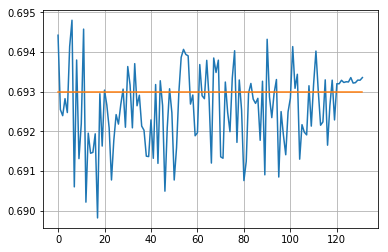

In [19]:
# Plotting the graph of results by eras

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(eras_list)
ax.plot(np.array([0.693 for i in range(len(eras_list))]))
ax.grid()

plt.show()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


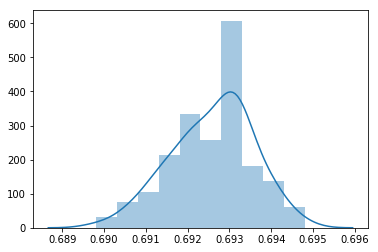

In [20]:
# Plot of distribution of the results of the NN predictions by era

sns.distplot(eras_list)

In [21]:
# Saving model and predicted results and submitting results to Numerai through NumerAPI

name_str = date_time_str()
ver_str = 'custom_activation_simple'

# Saving model
model_1.save('keras_models/%s.h5'%ver_str)

'''
To load saved model:

from keras.models import load_model
model_1 = load_model('keras_models/%s.h5'%ver_str)
'''

results_df = pd.DataFrame(data={'probability':score_nn_new.ravel()})
joined = pd.DataFrame(t_id).join(results_df)

# Saving results
if save_results:
    joined.to_csv(path_dir + '/submissions/'+ver_str+name_str+'.csv', index=False)

# Submitting and writing to log file
if submission:
    submission_id = napi.upload_predictions(path_dir + '/submissions/'+ver_str+name_str+'.csv')
    from time import sleep
    sleep(60)
    n = napi.submission_status()
    print(n)
    with open(path_dir + '/submissions/submission_log.txt','a') as file:
        file.write("\n"+list(keys.keys())[ai_num] +';'+name_str+';'+ver_str+';'+'corcondance:'+str(n['concordance']['value'])+';'+'originality:'+str(n['originality']['value'])+';'+'consistency:'+str(n['consistency'])+';'+'validation_logloss:'+str(n['validation_logloss']))